In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#smaller_df = pd.read_csv('winemag-data-130k-v2.csv')
larger_df = pd.read_csv('winemag-data_first150k.csv')

In [4]:
larger_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [54]:
print('~~~~~~~~~~~Row before dropping NAs: {}~~~~~~~~~~~'.format(len(larger_df)))
larger_df.dropna(subset=['price'], inplace=True)
print('~~~~~~~~~~~Row after dropping NAs: {}~~~~~~~~~~~'.format(len(larger_df)))


~~~~~~~~~~~Row before dropping NAs: 137235~~~~~~~~~~~
~~~~~~~~~~~Row after dropping NAs: 137235~~~~~~~~~~~


In [89]:
# Collect Data 
samples = 1000
max_price = 200
seed = 42

# Pull Italy
germany = larger_df[(larger_df.country=='Italy') & (larger_df.price<max_price)].sample(samples, random_state=seed)

# Pull US
united_states = larger_df[(larger_df.country=='US') & (larger_df.price<max_price)].sample(samples, random_state=seed)

# Pull Spain 
france = larger_df[(larger_df.country=='France') & (larger_df.price<max_price)].sample(samples, random_state=seed)


data_list = [germany, united_states, france]
wine_df = pd.concat(data_list)

wine_df.country.value_counts()


Italy     1000
France    1000
US        1000
Name: country, dtype: int64

In [90]:
# ANOVA Test 
model = ols('price ~ country', data=wine_df).fit()
anova = sm.stats.anova_lm(model, typ=2)

anova

,sum_sq,df,F,PR(>F)
country,6.039731e+03,2.0,4.069736,0.017176
Residual,2.223863e+06,2997.0,NaN,NaN


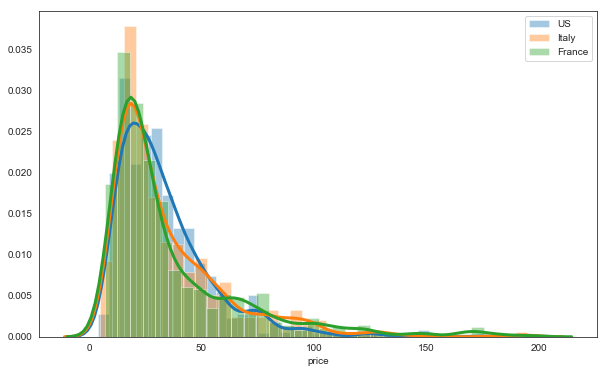

In [91]:
# Plot Price Distributions 
sns.set_style("white")
plt.figure(figsize=(10, 6))

for name in ['US', 'Italy', 'France']:
    sns.distplot(wine_df[wine_df.country==name].price, kde_kws=dict(linewidth=3))
    
    
plt.legend(['US', 'Italy', 'France'])
plt.show()

In [88]:
wine_df.groupby('country').mean()['price']

country
France    37.242
Italy     35.286
US        33.776
Name: price, dtype: float64

In [98]:
# Calculate Means 
mean_france = wine_df[wine_df.country == 'France']['price'].mean()
mean_italy = wine_df[wine_df.country == 'Italy']['price'].mean()
mean_us = wine_df[wine_df.country == 'US']['price'].mean()
mean_overall = wine_df['price'].mean()

# Calculate Variances 
var_france = wine_df[wine_df.country == 'France']['price'].var()
var_italy = wine_df[wine_df.country == 'Italy']['price'].var()
var_us = wine_df[wine_df.country == 'US']['price'].var()


In [116]:
# Sum of Squares Between
SSB = 1000*(mean_overall - mean_france)**2 + \
      1000*(mean_overall - mean_italy)**2 + \
      1000*(mean_overall - mean_us)**2 

print('Sum of Squares Between: {0:.6g}'.format(SSB))


# Sum of Squares Within 
SSW = 1000*var_france + \
      1000*var_italy + \
      1000*var_us

print('Sum of Squares Within: {0:.9g}'.format(SSW))


# Degrees of Freedom 
dof_SSB = 2
dof_SSW = 3000-3

print('Degrees of Freedom for SSB: {}'.format(dof_SSB))
print('Degrees of Freedom for SSW: {}'.format(dof_SSW))


# F Stastics 
f_stat = (SSB/dof_SSB) / (SSW/dof_SSW)

print('F-Statistic: {}'.format(f_stat))



Sum of Squares Between: 6039.73
Sum of Squares Within: 2226089.55
Degrees of Freedom for SSB: 2
Degrees of Freedom for SSW: 2997
F-Statistic: 4.065665907084648


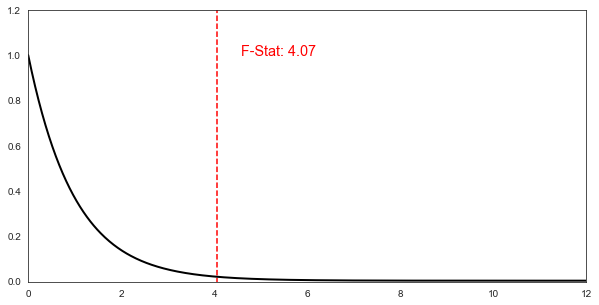

In [157]:
# F Distribution 
import numpy as np
from scipy.stats import f, norm
import matplotlib.pyplot as plt

# Plot Figure
plt.figure(figsize=(10, 5))
plt.xlim(0,12)
plt.ylim(-.005,1.2)

# Plot
dist = f(dfn=dof_SSB, dfd=dof_SSW, loc=0, scale=1)
x = np.linspace(dist.ppf(0.000001), dist.ppf(0.99999999), 1000)
y = dist.pdf(x) 

plt.plot(x,y, '-', color='black', linewidth=2)
plt.vlines(f_stat, color='red', ymin=-1, ymax=1.2, linestyle='--')
plt.text(x=f_stat+.5, y=1, s='F-Stat: {:.2f}'.format(f_stat), fontsize='x-large', color='red')

plt.show()